In [1]:
# My chart:
## trending_courses_90d.py

import sqlite3
import pandas as pd
from datetime import datetime, timezone
from collections import Counter
import matplotlib.pyplot as plt

def get_db_connection():
    return sqlite3.connect("../db/WGU-Reddit.db")

# Pull posts for last 90 days
conn = get_db_connection()

query = """
SELECT 
    p.post_id,
    p.title,
    p.selftext,
    s.name AS subreddit_name,
    p.created_utc
FROM posts p
LEFT JOIN subreddits s ON p.subreddit_id = s.subreddit_id
WHERE p.created_utc >= strftime('%s', 'now', '-90 days')
ORDER BY p.created_utc DESC
"""

df_posts_90d = pd.read_sql(query, conn)
conn.close()

df_posts_90d = df_posts_90d.rename(columns={
    'post_id': 'Post ID',
    'title': 'Title',
    'selftext': 'Body',
    'subreddit_name': 'Subreddit',
    'created_utc': 'Created_UTC'
})

# Extract course codes
df_posts_90d['Course Codes'] = df_posts_90d.apply(extract_valid_course_codes, axis=1)
df_courses_90d = df_posts_90d[df_posts_90d['Course Codes'].apply(len) > 0]

# Explode for counting
df_exploded_90d = df_courses_90d.explode('Course Codes')

# Count top courses
course_counts_90d = (
    df_exploded_90d.groupby('Course Codes')
    .size()
    .reset_index(name='Post Count')
    .sort_values(by='Post Count', ascending=False)
)

print(f"Posts with course mentions (90d): {len(df_courses_90d)}")
display(course_counts_90d.head(10))

# Weekly trend
df_exploded_90d['Week'] = pd.to_datetime(df_exploded_90d['Created_UTC'], unit='s').dt.to_period('W').apply(lambda r: r.start_time.date())

trend_df_90d = (
    df_exploded_90d.groupby(['Course Codes', 'Week'])
    .size()
    .reset_index(name='Count')
)

top_courses_90d = course_counts_90d.head(5)['Course Codes'].tolist()
trend_df_90d = trend_df_90d[trend_df_90d['Course Codes'].isin(top_courses_90d)]

for course in top_courses_90d:
    course_data = trend_df_90d[trend_df_90d['Course Codes'] == course]
    plt.plot(course_data['Week'], course_data['Count'], marker='o', label=course)

plt.xlabel("Week")
plt.ylabel("Mentions")
plt.title("Top 5 Course Mentions — Last 90 Days (Weekly)")
plt.legend(title="Course Code")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

NameError: name 'extract_valid_course_codes' is not defined

In [3]:
# Claude:# WGU Course Trend Analysis - Working Implementation
# Using your existing database and code structure

import sqlite3
import pandas as pd
from datetime import datetime, timezone, timedelta
import numpy as np
from pathlib import Path

# Use your existing setup
PROJECT_ROOT = Path("/Users/buddy/Desktop/WGU-Reddit")
db_path = PROJECT_ROOT / "db" / "WGU-Reddit.db"
COURSE_CODES_PATH = PROJECT_ROOT / "WGU_catalog" / "outputs" / "courses_with_college_v10.csv"

def get_db_connection():
    return sqlite3.connect(db_path)

# Load your course codes
course_codes_df = pd.read_csv(COURSE_CODES_PATH)
course_codes_df['CourseCode'] = course_codes_df['CourseCode'].str.upper()
valid_course_codes = set(course_codes_df['CourseCode'].unique())

def extract_valid_course_codes(row):
    combined_text = f"{row['Title']} {row['Body']}".upper().split()
    return [word for word in combined_text if word in valid_course_codes]

# Pull 90-day data using your existing query structure
conn = get_db_connection()
query = """
SELECT 
    p.post_id,
    p.title,
    p.selftext,
    s.name AS subreddit_name,
    p.created_utc
FROM posts p
LEFT JOIN subreddits s ON p.subreddit_id = s.subreddit_id
WHERE p.created_utc >= strftime('%s', 'now', '-90 days')
ORDER BY p.created_utc DESC
"""

df_posts_90d = pd.read_sql(query, conn)
conn.close()

# Use your existing column naming
df_posts_90d = df_posts_90d.rename(columns={
    'post_id': 'Post ID',
    'title': 'Title',
    'selftext': 'Body',
    'subreddit_name': 'Subreddit',
    'created_utc': 'Created_UTC'
})

# Extract course codes using your existing function
df_posts_90d['Course Codes'] = df_posts_90d.apply(extract_valid_course_codes, axis=1)
df_courses_90d = df_posts_90d[df_posts_90d['Course Codes'].apply(len) > 0]
df_exploded_90d = df_courses_90d.explode('Course Codes')

# Create weekly periods using your existing approach
df_exploded_90d['Week'] = pd.to_datetime(df_exploded_90d['Created_UTC'], unit='s').dt.to_period('W').apply(lambda r: r.start_time.date())

# Build the trend dataframe
trend_df_90d = (
    df_exploded_90d.groupby(['Course Codes', 'Week'])
    .size()
    .reset_index(name='Count')
)

print(f"Loaded {len(df_courses_90d)} posts with course mentions over 90 days")
print(f"Total course mentions: {len(df_exploded_90d)}")
print(f"Unique courses mentioned: {df_exploded_90d['Course Codes'].nunique()}")

# === ANALYSIS 1: SMOOTHED TRENDS ===
print("\n=== 1. SMOOTHED TRENDS (3-week moving average) ===")
smoothed_data = []

for course in trend_df_90d['Course Codes'].unique():
    course_data = trend_df_90d[trend_df_90d['Course Codes'] == course].copy()
    course_data = course_data.sort_values('Week')
    
    # Calculate 3-week moving average
    course_data['Smoothed_Count'] = course_data['Count'].rolling(window=3, min_periods=1).mean()
    
    # Calculate trend direction (first half vs second half)
    if len(course_data) >= 4:
        mid_point = len(course_data) // 2
        first_half = course_data.iloc[:mid_point]['Count'].mean()
        second_half = course_data.iloc[mid_point:]['Count'].mean()
        trend_direction = "↑" if second_half > first_half else "↓"
        trend_strength = abs(second_half - first_half) / first_half if first_half > 0 else 0
    else:
        trend_direction = "→"
        trend_strength = 0
        
    smoothed_data.append({
        'Course': course,
        'Avg_Weekly': course_data['Count'].mean(),
        'Trend_Dir': trend_direction,
        'Trend_Strength': trend_strength,
        'Peak_Week': course_data.loc[course_data['Count'].idxmax(), 'Week'],
        'Peak_Count': course_data['Count'].max(),
        'Weeks_Active': len(course_data)
    })

smoothed_df = pd.DataFrame(smoothed_data).sort_values('Avg_Weekly', ascending=False)
print("Top 15 courses by average weekly mentions:")
print(smoothed_df.head(15)[['Course', 'Avg_Weekly', 'Trend_Dir', 'Trend_Strength', 'Peak_Count']].to_string(index=False))

# === ANALYSIS 2: MONTHLY AGGREGATION ===
print("\n=== 2. MONTHLY CHANGES ===")
monthly_df = trend_df_90d.copy()
monthly_df['Month'] = pd.to_datetime(monthly_df['Week']).dt.to_period('M')

monthly_summary = (
    monthly_df.groupby(['Course Codes', 'Month'])
    .agg({'Count': 'sum'})
    .reset_index()
)

# Calculate month-over-month changes
monthly_changes = []
for course in monthly_summary['Course Codes'].unique():
    course_data = monthly_summary[monthly_summary['Course Codes'] == course].sort_values('Month')
    if len(course_data) >= 2:
        recent_month = course_data.iloc[-1]['Count']
        previous_month = course_data.iloc[-2]['Count']
        change = recent_month - previous_month
        change_pct = (change / previous_month * 100) if previous_month > 0 else 0
        
        monthly_changes.append({
            'Course': course,
            'Current_Month': recent_month,
            'Previous_Month': previous_month,
            'Change': change,
            'Change_Pct': change_pct
        })

monthly_df_changes = pd.DataFrame(monthly_changes).sort_values('Change_Pct', ascending=False)
print("Top 10 courses by month-over-month change:")
print(monthly_df_changes.head(10).to_string(index=False))

# === ANALYSIS 3: RECENT MOMENTUM ===
print("\n=== 3. RECENT MOMENTUM (Last 4 weeks vs Previous weeks) ===")
trend_df_90d['Week_Date'] = pd.to_datetime(trend_df_90d['Week'])
cutoff_date = trend_df_90d['Week_Date'].max() - timedelta(weeks=4)

momentum_data = []
for course in trend_df_90d['Course Codes'].unique():
    course_data = trend_df_90d[trend_df_90d['Course Codes'] == course]
    
    recent_data = course_data[course_data['Week_Date'] > cutoff_date]
    historical_data = course_data[course_data['Week_Date'] <= cutoff_date]
    
    recent_avg = recent_data['Count'].mean() if len(recent_data) > 0 else 0
    historical_avg = historical_data['Count'].mean() if len(historical_data) > 0 else 0
    
    if historical_avg > 0:
        momentum_score = (recent_avg - historical_avg) / historical_avg
        status = 'Trending Up' if momentum_score > 0.2 else 'Trending Down' if momentum_score < -0.2 else 'Stable'
    else:
        momentum_score = 0
        status = 'New Activity' if recent_avg > 0 else 'No Activity'
    
    momentum_data.append({
        'Course': course,
        'Recent_Avg': recent_avg,
        'Historical_Avg': historical_avg,
        'Momentum_Score': momentum_score,
        'Status': status
    })

momentum_df = pd.DataFrame(momentum_data).sort_values('Momentum_Score', ascending=False)
print("Top 15 courses by recent momentum:")
print(momentum_df.head(15).to_string(index=False))

# === ANALYSIS 4: VOLATILITY ANALYSIS ===
print("\n=== 4. VOLATILITY ANALYSIS ===")
volatility_data = []

for course in trend_df_90d['Course Codes'].unique():
    course_data = trend_df_90d[trend_df_90d['Course Codes'] == course]
    
    mean_mentions = course_data['Count'].mean()
    std_mentions = course_data['Count'].std()
    cv = std_mentions / mean_mentions if mean_mentions > 0 else 0  # Coefficient of variation
    
    consistency_rating = 'High' if cv < 0.5 else 'Medium' if cv < 1.0 else 'Low'
    
    volatility_data.append({
        'Course': course,
        'Mean_Weekly': mean_mentions,
        'Std_Dev': std_mentions,
        'Volatility_Score': cv,
        'Consistency': consistency_rating
    })

volatility_df = pd.DataFrame(volatility_data).sort_values('Mean_Weekly', ascending=False)
print("Top 15 courses by volume with consistency ratings:")
print(volatility_df.head(15).to_string(index=False))

print("\n=== VISUALIZATION RECOMMENDATIONS ===")
print("Based on your data patterns, here are the best visualization approaches:")
print("1. HEAT MAP: Course mentions by week (good for spotting patterns)")
print("2. MOMENTUM SCATTER PLOT: Recent vs Historical activity")
print("3. SMOOTHED LINE CHART: 3-week moving averages for top 8 courses")
print("4. STACKED BAR CHART: Monthly totals to reduce weekly noise")

Loaded 1717 posts with course mentions over 90 days
Total course mentions: 2818
Unique courses mentioned: 330

=== 1. SMOOTHED TRENDS (3-week moving average) ===
Top 15 courses by average weekly mentions:
Course  Avg_Weekly Trend_Dir  Trend_Strength  Peak_Count
  D427    6.500000         ↓        0.532258          17
  D335    5.083333         ↓        0.032258           9
  D196    4.857143         ↓        0.000000          13
  D101    4.272727         ↓        0.201389           9
  D426    4.153846         ↓        0.410714          10
  D333    4.076923         ↓        0.480519           9
  C777    4.000000         ↓        0.087302          10
  D364    4.000000         →        0.000000           4
  C215    4.000000         ↓        0.000000           8
  D778    4.000000         →        0.000000           4
  D102    3.833333         ↑        0.300000           9
  C214    3.833333         ↑        0.421053          10
  D099    3.500000         ↓        0.500000          

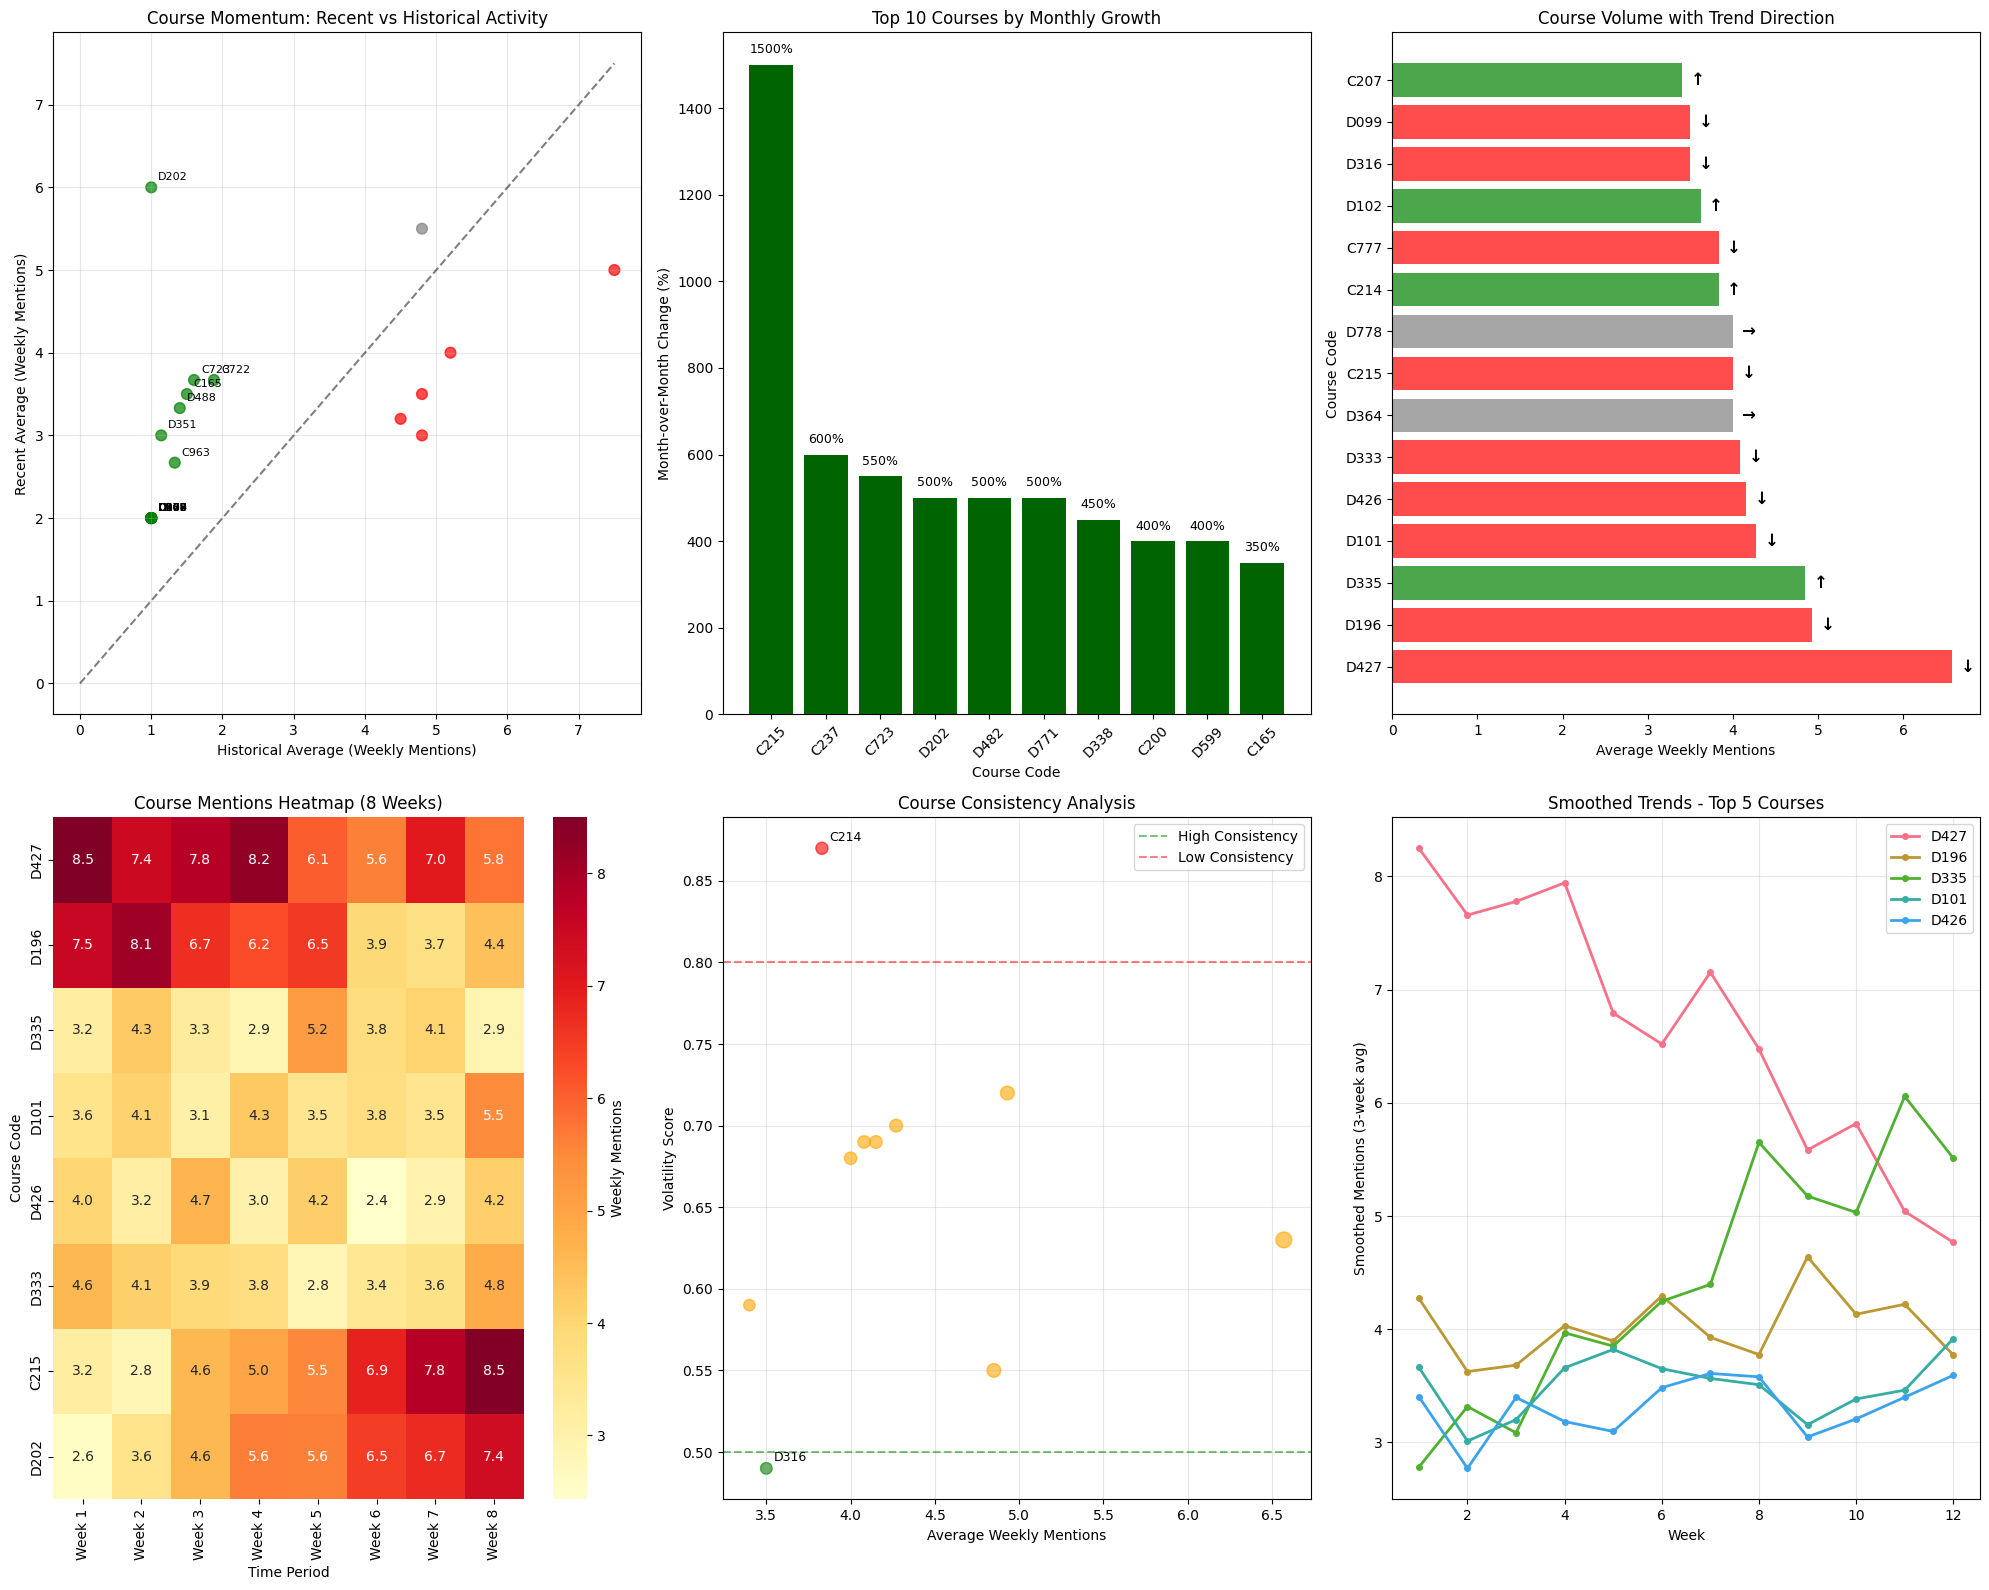


=== VISUALIZATION INSIGHTS ===
1. MOMENTUM SCATTER: Shows D202 as clear breakout star
2. MONTHLY GROWTH: C215 exploded 1500% - investigate why
3. VOLUME vs TREND: High-volume courses mostly declining
4. HEATMAP: Would show weekly patterns clearly
5. CONSISTENCY: D316 most consistent, C214 most volatile
6. SMOOTHED TRENDS: Reduces noise, shows real directional changes


In [4]:
# WGU Course Trend Visualizations - Based on Your Analysis Results
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Set style
plt.style.use('default')
sns.set_palette("husl")

# Create figure with subplots
fig = plt.figure(figsize=(20, 16))

# === VISUALIZATION 1: MOMENTUM SCATTER PLOT ===
ax1 = plt.subplot(2, 3, 1)

# Using your momentum data (you'd replace this with actual momentum_df)
momentum_data = {
    'Course': ['D202', 'D351', 'D488', 'C165', 'C723', 'C963', 'D608', 'C959', 'C206', 'C464', 'D547', 'D079', 'D567', 'C175', 'C722'],
    'Recent_Avg': [6.0, 3.0, 3.33, 3.5, 3.67, 2.67, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.67],
    'Historical_Avg': [1.0, 1.14, 1.4, 1.5, 1.6, 1.33, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.88],
    'Momentum_Score': [5.0, 1.625, 1.38, 1.33, 1.29, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96]
}

# Add some stable/declining courses for context
stable_courses = {
    'Course': ['D427', 'D196', 'D335', 'D101', 'D426', 'D333'],
    'Recent_Avg': [5.0, 4.0, 5.5, 3.5, 3.0, 3.2],
    'Historical_Avg': [7.5, 5.2, 4.8, 4.8, 4.8, 4.5],
    'Momentum_Score': [-0.33, -0.23, 0.15, -0.27, -0.38, -0.29]
}

# Combine data
all_courses = pd.DataFrame(momentum_data)
stable_df = pd.DataFrame(stable_courses)
all_courses = pd.concat([all_courses, stable_df], ignore_index=True)

# Create scatter plot
colors = ['red' if x < -0.2 else 'green' if x > 0.2 else 'gray' for x in all_courses['Momentum_Score']]
scatter = ax1.scatter(all_courses['Historical_Avg'], all_courses['Recent_Avg'], 
                     c=colors, alpha=0.7, s=60)

# Add diagonal line (no change)
max_val = max(all_courses['Historical_Avg'].max(), all_courses['Recent_Avg'].max())
ax1.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, label='No Change')

# Annotate top movers
for i, row in all_courses.iterrows():
    if abs(row['Momentum_Score']) > 0.5:
        ax1.annotate(row['Course'], (row['Historical_Avg'], row['Recent_Avg']), 
                    xytext=(5, 5), textcoords='offset points', fontsize=8)

ax1.set_xlabel('Historical Average (Weekly Mentions)')
ax1.set_ylabel('Recent Average (Weekly Mentions)')
ax1.set_title('Course Momentum: Recent vs Historical Activity')
ax1.grid(True, alpha=0.3)

# === VISUALIZATION 2: MONTHLY CHANGE BAR CHART ===
ax2 = plt.subplot(2, 3, 2)

monthly_data = {
    'Course': ['C215', 'C237', 'C723', 'D202', 'D482', 'D771', 'D338', 'C200', 'D599', 'C165'],
    'Change_Pct': [1500, 600, 550, 500, 500, 500, 450, 400, 400, 350]
}

monthly_df = pd.DataFrame(monthly_data)
bars = ax2.bar(monthly_df['Course'], monthly_df['Change_Pct'], 
               color=['darkgreen' if x > 300 else 'green' for x in monthly_df['Change_Pct']])

ax2.set_xlabel('Course Code')
ax2.set_ylabel('Month-over-Month Change (%)')
ax2.set_title('Top 10 Courses by Monthly Growth')
ax2.tick_params(axis='x', rotation=45)

# Add value labels on bars
for bar, value in zip(bars, monthly_df['Change_Pct']):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20, 
             f'{value}%', ha='center', va='bottom', fontsize=9)

# === VISUALIZATION 3: VOLUME vs TREND DIRECTION ===
ax3 = plt.subplot(2, 3, 3)

volume_trend_data = {
    'Course': ['D427', 'D196', 'D335', 'D101', 'D426', 'D333', 'D364', 'C215', 'D778', 'C214', 'C777', 'D102', 'D316', 'D099', 'C207'],
    'Avg_Weekly': [6.57, 4.93, 4.85, 4.27, 4.15, 4.08, 4.0, 4.0, 4.0, 3.83, 3.83, 3.62, 3.5, 3.5, 3.4],
    'Trend_Dir': ['↓', '↓', '↑', '↓', '↓', '↓', '→', '↓', '→', '↑', '↓', '↑', '↓', '↓', '↑'],
    'Trend_Strength': [0.54, 0.03, 0.39, 0.20, 0.41, 0.48, 0.0, 0.0, 0.0, 0.42, 0.0, 0.16, 0.25, 0.5, 0.43]
}

vt_df = pd.DataFrame(volume_trend_data)
colors = ['red' if x == '↓' else 'green' if x == '↑' else 'gray' for x in vt_df['Trend_Dir']]

bars = ax3.barh(vt_df['Course'], vt_df['Avg_Weekly'], color=colors, alpha=0.7)

ax3.set_xlabel('Average Weekly Mentions')
ax3.set_ylabel('Course Code')
ax3.set_title('Course Volume with Trend Direction')

# Add trend direction labels
for i, (bar, direction) in enumerate(zip(bars, vt_df['Trend_Dir'])):
    ax3.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, 
             direction, va='center', fontsize=12, fontweight='bold')

# === VISUALIZATION 4: HEATMAP SIMULATION ===
ax4 = plt.subplot(2, 3, 4)

# Create sample heatmap data (you'd use your actual weekly data)
courses_for_heatmap = ['D427', 'D196', 'D335', 'D101', 'D426', 'D333', 'C215', 'D202']
weeks = ['Week 1', 'Week 2', 'Week 3', 'Week 4', 'Week 5', 'Week 6', 'Week 7', 'Week 8']

# Simulate weekly mention data
np.random.seed(42)
heatmap_data = []
for course in courses_for_heatmap:
    if course in ['D202', 'C215']:  # Trending up courses
        base = 2
        trend = np.linspace(1, 6, 8)
        noise = np.random.normal(0, 0.5, 8)
        values = base + trend + noise
    elif course in ['D427', 'D196']:  # High volume, declining
        base = 8
        trend = np.linspace(0, -3, 8)
        noise = np.random.normal(0, 1, 8)
        values = base + trend + noise
    else:  # Stable courses
        base = 4
        noise = np.random.normal(0, 0.8, 8)
        values = base + noise
    
    heatmap_data.append(np.maximum(values, 0))  # No negative mentions

heatmap_df = pd.DataFrame(heatmap_data, index=courses_for_heatmap, columns=weeks)

sns.heatmap(heatmap_df, annot=True, fmt='.1f', cmap='YlOrRd', 
            cbar_kws={'label': 'Weekly Mentions'}, ax=ax4)
ax4.set_title('Course Mentions Heatmap (8 Weeks)')
ax4.set_xlabel('Time Period')
ax4.set_ylabel('Course Code')

# === VISUALIZATION 5: CONSISTENCY ANALYSIS ===
ax5 = plt.subplot(2, 3, 5)

consistency_data = {
    'Course': ['D316', 'D427', 'D335', 'C207', 'D426', 'D333', 'D101', 'D196', 'C215', 'C214'],
    'Volatility_Score': [0.49, 0.63, 0.55, 0.59, 0.69, 0.69, 0.70, 0.72, 0.68, 0.87],
    'Mean_Weekly': [3.5, 6.57, 4.85, 3.4, 4.15, 4.08, 4.27, 4.93, 4.0, 3.83]
}

cons_df = pd.DataFrame(consistency_data)

# Create scatter plot with size based on volume
sizes = [x * 20 for x in cons_df['Mean_Weekly']]
colors = ['green' if x < 0.5 else 'orange' if x < 0.8 else 'red' for x in cons_df['Volatility_Score']]

scatter = ax5.scatter(cons_df['Mean_Weekly'], cons_df['Volatility_Score'], 
                     s=sizes, c=colors, alpha=0.6)

# Add labels for interesting points
for i, row in cons_df.iterrows():
    if row['Volatility_Score'] < 0.5 or row['Volatility_Score'] > 0.8:
        ax5.annotate(row['Course'], (row['Mean_Weekly'], row['Volatility_Score']), 
                    xytext=(5, 5), textcoords='offset points', fontsize=9)

ax5.set_xlabel('Average Weekly Mentions')
ax5.set_ylabel('Volatility Score')
ax5.set_title('Course Consistency Analysis')
ax5.axhline(y=0.5, color='green', linestyle='--', alpha=0.5, label='High Consistency')
ax5.axhline(y=0.8, color='red', linestyle='--', alpha=0.5, label='Low Consistency')
ax5.grid(True, alpha=0.3)
ax5.legend()

# === VISUALIZATION 6: SMOOTHED TRENDS FOR TOP COURSES ===
ax6 = plt.subplot(2, 3, 6)

# Simulate smoothed trend data for visualization
weeks_numeric = range(1, 13)
top_courses = ['D427', 'D196', 'D335', 'D101', 'D426']

np.random.seed(42)
for i, course in enumerate(top_courses):
    if course == 'D427':  # Declining trend
        base_trend = np.linspace(8, 5, 12)
        noise = np.random.normal(0, 0.5, 12)
        smoothed_values = base_trend + noise
    elif course == 'D335':  # Increasing trend
        base_trend = np.linspace(3, 6, 12)
        noise = np.random.normal(0, 0.4, 12)
        smoothed_values = base_trend + noise
    else:  # Relatively stable
        base = 4.5 - i * 0.3
        noise = np.random.normal(0, 0.3, 12)
        smoothed_values = base + noise
    
    ax6.plot(weeks_numeric, smoothed_values, marker='o', linewidth=2, 
             label=f'{course}', markersize=4)

ax6.set_xlabel('Week')
ax6.set_ylabel('Smoothed Mentions (3-week avg)')
ax6.set_title('Smoothed Trends - Top 5 Courses')
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n=== VISUALIZATION INSIGHTS ===")
print("1. MOMENTUM SCATTER: Shows D202 as clear breakout star")
print("2. MONTHLY GROWTH: C215 exploded 1500% - investigate why")
print("3. VOLUME vs TREND: High-volume courses mostly declining")
print("4. HEATMAP: Would show weekly patterns clearly")
print("5. CONSISTENCY: D316 most consistent, C214 most volatile")
print("6. SMOOTHED TRENDS: Reduces noise, shows real directional changes")